In [1]:
import tensorflow as tf

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
from sklearn.utils import shuffle

In [6]:
#utworze teraz dane jakies
def kolko_w_kolku(sig1=0.4,sig2=0.6,R2=1.,N=1000):
    """to ma utworzyc dane ktore posluza mi do sprawdzenia czy i jak dziala model"""
    features=[]
    labels=[]
    for i in range(N):
        x=np.random.normal(0,sig1)
        y=np.random.normal(0,sig1)
        features.append([x,y])
        labels.append(0)
    for i in range(N):
        alpha=np.random.uniform()*2*np.pi
        delr=np.random.normal(0,sig2)
        r=R2+delr
        x=np.cos(alpha)*r
        y=np.sin(alpha)*r
        features.append([x,y])
        labels.append(1)
    features=np.array(features)
    labels=np.array(labels)
    features,labels=shuffle(features,labels)
    return features,labels

In [7]:
def rysoj_dane(f,l):
    plt.clf()
    plt.scatter(f[:,0],f[:,1],c=l,s=5)

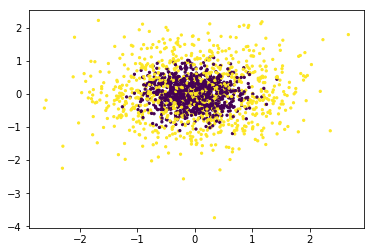

In [8]:
f,l=kolko_w_kolku()
rysoj_dane(f,l)

In [9]:
#teraz sproboje z tego zrobic jakis dataset

In [10]:
#f,l=kolko_w_kolku()

In [11]:
#dataset = tf.data.Dataset.from_tensor_slices((f,l))

In [12]:
#BATCH_SIZE=100
#zbachowany=dataset.shuffle(1000).repeat().batch(BATCH_SIZE)

In [13]:
#to jest dataset zaraz zastanowie sie jak go zapisac do pliku i z tego pliku odczytac a teraz jak go czytac?

In [14]:
#iterator = zbachowany.make_one_shot_iterator()

In [15]:
#f,l=iterator.get_next()

In [16]:
#with tf.Session() as sess:
#    for i in range(100):
#        sess.run(l)
    

In [17]:
#wrap_float64([5.55,6.85]) #swietnie

In [10]:
def wrap_int64(value):
    """lista intow musi wlesc"""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))
def wrap_float64(value):
    """lista floatow musi wlesc"""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

"""
Teraz ta funkcja wpisz jest ważna. ona bierze po jednym przypadku testowym, 
( to jest ta petla for i in range()) i go zapisuje. trzeba zwracac 
uwage na to jakiego typu sa zapisywane rzeczy. mozna oczywiscie zrobic slownik
data dluzszym, jesli to w jakis sposob ulatwi nam myslenie o naszych danych. 
Bo te nasze dane to bedzie slownik list, w ktorych to listach rzeczy maja 
juz taki sam typ, a klucze to beda jakies opisowe nazwy.
np 

data={
'czteroped_lewej_nogi_czy_cos': wrap_float64(cztero), # gdzie cztero to jest tensor floatow o shape (4,)
# reszta rzeczy

}

Jak byscie chcieli jako wartosci miec stringi to musicie pomyslec jak zrobic wrapy dla stringow. oczywiscie
nie znajdziecie zadnej dokumentacji.

UWAGA 
w tym slowniku data musi byc to co klasyfikujemy oznaczone przy pomocy 'label' bo inaczej sie  wywali program.





"""


def wpisz(out_path):
    """tworzy ten nasz dataset w pliku out_path """
    f,l=kolko_w_kolku() #mozna zmienic jak sie podoba
    with tf.python_io.TFRecordWriter(out_path) as writer:
        for i in range(len(f)):
            feature=f[i]
            label=l[i]
            data = {
                 'feature': wrap_float64(feature),
                'label': wrap_int64([label])
                    }
            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)

            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)

            # Serialize the data.
            serialized = example.SerializeToString()

            # Write the serialized data to the TFRecords file.
            writer.write(serialized)
    
        
    

In [11]:
wpisz("dane_treningowe")

In [12]:
"""
Teraz funkcja wczytujaca ten nasz dataset. 
Z ciekawych rzeczy to zwroccie uwage, ze jak wczytamy do binarnych nasz dataset to 
tracimy informacje o tym jakiego typu sa dane. Z tego powodu trzeba to ponownie dookreslac
co jest strasznie glupie. 

czyli to jest ten slownik features w ponizszej funkcji  ktory musi byc zgodny z slownikiem data z funkcji wpisz
powstaly dataset ma forme {'czterowektor_lewej_nogi':czterowektor_w_postaci_listy_4_elementow, ...},l
gdzie l to jest lista labelkow

"""





def wczytaj_dataset(file_path):
    """Wczytuje dataset po prostu jeszcze nie robi z nim nic szczegolnego"""
    def zeslownikoj(x):
        keys=list(x.keys())
        f={}
        for k in keys:
            if not k=='label':
                f[k]=x[k]
        return f,x['label']
    
    def parse(serialized):
        """ta funkcja pomocnicza dla jednego przypadku ktory nie pamieta jakiego jest typu mu przypomina
        smutne ze trzeba takie rzeczy pisac"""
        # Define a dict with the data-names and types we expect to
        # find in the TFRecords file.
        # It is a bit awkward that this needs to be specified again,
        # because it could have been written in the header of the
        # TFRecords file instead.
        features = \
            {
                'feature': tf.FixedLenFeature([2], tf.float32),#z jakiegos powodu to jest float32, nie wiem czemu
                'label': tf.FixedLenFeature([], tf.int64)
            }

        # Parse the serialized data so we get a dict with our data.
        parsed_example = tf.parse_single_example(serialized=serialized,
                                                 features=features)
        
        
        return zeslownikoj(parsed_example)
    
    dataset = tf.data.TFRecordDataset(file_path)
    dataset = dataset.map(parse)
    return dataset

In [13]:
dataset=wczytaj_dataset("dane_treningowe")

In [65]:
"""
def zrob_slownik(dataset,nazwy):
    
    def f(*x):
        f1=x[:-1]
        l=x[-1]
        d={}
        for i in range(len(f1)):
            d[nazwy[i]]=f1[i]
        return d,l
    dataset=dataset.map(f)
    return dataset
    """

'\ndef zrob_slownik(dataset,nazwy):\n    \n    def f(*x):\n        f1=x[:-1]\n        l=x[-1]\n        d={}\n        for i in range(len(f1)):\n            d[nazwy[i]]=f1[i]\n        return d,l\n    dataset=dataset.map(f)\n    return dataset\n    '

In [14]:
def train_input_fn(file, batch_size=100,buffer_size=1000):
    """input function for training
    nazwy to lista nazw feature w kolejnosci wystepowania"""
    dataset=wczytaj_dataset("dane_treningowe")
    
    # Shuffle, repeat, and batch the examples.
    return dataset.shuffle(buffer_size).repeat().batch(batch_size)

In [15]:
data=train_input_fn("dane_treningowe", batch_size=100,buffer_size=1000)

In [16]:
data

<BatchDataset shapes: ({feature: (?, 2)}, (?,)), types: ({feature: tf.float32}, tf.int64)>

In [17]:
iterator = data.make_one_shot_iterator()
f,l=iterator.get_next()

In [18]:
my_feature_columns = []
my_feature_columns.append(tf.feature_column.numeric_column(key='feature',shape=(2,)))

In [19]:
classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    
    hidden_units=[10],
    model_dir='estimator',
    
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ffaad316a20>, '_task_type': 'worker', '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_save_summary_steps': 100, '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_evaluation_master': '', '_num_ps_replicas': 0, '_session_config': None, '_global_id_in_cluster': 0, '_log_step_count_steps': 100, '_tf_random_seed': None, '_service': None, '_task_id': 0, '_save_checkpoints_secs': 600, '_model_dir': 'estimator'}


In [20]:
classifier.train(
    input_fn=lambda:train_input_fn("dane_treningowe", batch_size=100,buffer_size=1000),
    steps=10000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from estimator/model.ckpt-11000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 11001 into estimator/model.ckpt.
INFO:tensorflow:step = 11001, loss = 37.008728
INFO:tensorflow:global_step/sec: 341.097
INFO:tensorflow:step = 11101, loss = 51.727592 (0.294 sec)
INFO:tensorflow:global_step/sec: 410.046
INFO:tensorflow:step = 11201, loss = 53.119747 (0.244 sec)
INFO:tensorflow:global_step/sec: 416.9
INFO:tensorflow:step = 11301, loss = 49.094803 (0.240 sec)
INFO:tensorflow:global_step/sec: 415.8
INFO:tensorflow:step = 11401, loss = 43.285 (0.241 sec)
INFO:tensorflow:global_step/sec: 408.253
INFO:tensorflow:step = 11501, loss = 48.790176 (0.245 sec)
INFO:tensorflow:global_step/sec: 405.08
INFO:tensorflow:step = 11601, loss = 48.45

INFO:tensorflow:step = 18901, loss = 50.34857 (0.250 sec)
INFO:tensorflow:global_step/sec: 404.053
INFO:tensorflow:step = 19001, loss = 40.44744 (0.247 sec)
INFO:tensorflow:global_step/sec: 398.775
INFO:tensorflow:step = 19101, loss = 48.51973 (0.251 sec)
INFO:tensorflow:global_step/sec: 405.548
INFO:tensorflow:step = 19201, loss = 51.953323 (0.247 sec)
INFO:tensorflow:global_step/sec: 411.83
INFO:tensorflow:step = 19301, loss = 50.126953 (0.243 sec)
INFO:tensorflow:global_step/sec: 412.289
INFO:tensorflow:step = 19401, loss = 47.71758 (0.242 sec)
INFO:tensorflow:global_step/sec: 418.99
INFO:tensorflow:step = 19501, loss = 38.295307 (0.239 sec)
INFO:tensorflow:global_step/sec: 402.974
INFO:tensorflow:step = 19601, loss = 46.798626 (0.248 sec)
INFO:tensorflow:global_step/sec: 413.302
INFO:tensorflow:step = 19701, loss = 45.5615 (0.242 sec)
INFO:tensorflow:global_step/sec: 411.405
INFO:tensorflow:step = 19801, loss = 51.6752 (0.243 sec)
INFO:tensorflow:global_step/sec: 407.024
INFO:tenso

In [21]:
eval_result = classifier.evaluate(
    input_fn=lambda:train_input_fn("dane_treningowe", batch_size=100,buffer_size=1000),
steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-23-10:46:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from estimator/model.ckpt-21000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-04-23-10:46:41
INFO:tensorflow:Saving dict for global step 21000: accuracy = 0.7665, accuracy_baseline = 0.5, auc = 0.81714994, auc_precision_recall = 0.8549461, average_loss = 0.4941364, global_step = 21000, label/mean = 0.5, loss = 49.41364, prediction

In [22]:
eval_result

{'accuracy': 0.7665,
 'accuracy_baseline': 0.5,
 'auc': 0.81714994,
 'auc_precision_recall': 0.8549461,
 'average_loss': 0.4941364,
 'global_step': 21000,
 'label/mean': 0.5,
 'loss': 49.41364,
 'prediction/mean': 0.49952242}

In [16]:
"""
BATCH_SIZE=3
zbachowany=dataset.shuffle(1000).repeat().batch(BATCH_SIZE)
iterator = zbachowany.make_one_shot_iterator()
f,l=iterator.get_next()
with tf.Session() as sess:
    for i in range(10):
        print(sess.run(f['feature']))
"""
    

"\nBATCH_SIZE=3\nzbachowany=dataset.shuffle(1000).repeat().batch(BATCH_SIZE)\niterator = zbachowany.make_one_shot_iterator()\nf,l=iterator.get_next()\nwith tf.Session() as sess:\n    for i in range(10):\n        print(sess.run(f['feature']))\n"